In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import re
import itertools
import time
import joblib
import random

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
parsl.load(config)

#parsl.load()

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
training_fraction = 0.85

In [5]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [18]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly']
features = callers + ['confidence'] # FIXME prepend caller to feature names
indices = dict((c, i) for i, c in enumerate(features))

In [19]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [20]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [26]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [27]:
training_data = [apps.assemble_data(sample, callers, out_dir) for sample in training_samples]

start = time.time()
x_train = np.array(sum([data.result()[0] for data in training_data], []))
y_train = np.array(sum([data.result()[1] for data in training_data], []))

print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 38.7s


In [58]:
start = time.time()
x_train, y_train = apps.assemble_data(training_samples, callers, out_dir)

print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 37.9s


In [59]:
#x_train = x_train.to_numpy()

In [60]:
#pruned_indices = [indices[f] for f in features]
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)

classifiers = []
for features in [
            ['pizzly', 'starfusion', 'arriba', 'fusioncatcher'],
            callers + ['confidence'],
        ]:
    #label = 'LSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.LinearSVC(probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]


    #label = 'DefaultSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(probability=True)
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]

    #label = 'SVC{}Features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(C=10, gamma='auto', probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]
    
    label = 'RFC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.RandomForestClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]

    
    label = 'GBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=750, subsample=0.9)
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]

    label = 'DefaultGBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]

print('fit models in {:.1f}s'.format((time.time() - start)))


fit models in 113.2s


In [52]:
x_train.shape, sum(y_train)

((63025, 6), 34000)

In [61]:
# TODO make helper function to ensure this file exists
start = time.time()
futures = []
for sample in testing_samples:
    for features, label, transformation in classifiers:
        feature_indices = [indices[f] for f in features]
        futures += [apps.predict(sample, out_dir, label, feature_indices, transformation, callers)]
model_data = pd.concat([f.result() for f in futures])
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled predictions in 35.2s


In [62]:
model_data.to_hdf(os.path.join(out_dir, 'model_data.hdf'), 'data', mode='w')

In [63]:
summary = apps.make_summary(out_dir, testing_samples)

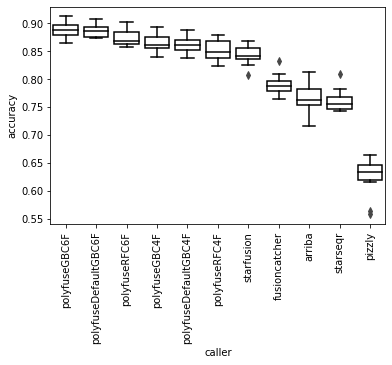

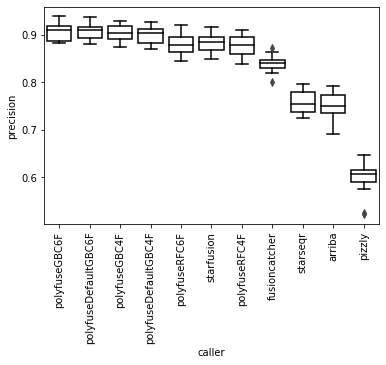

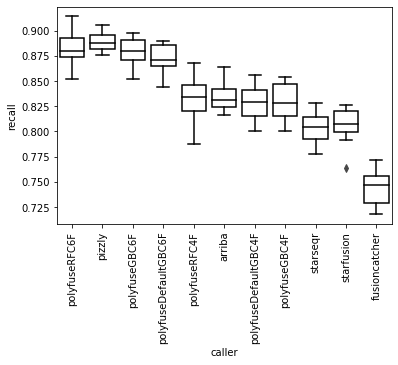

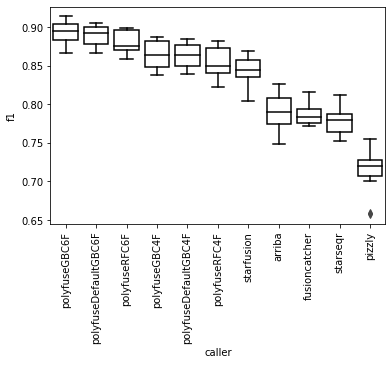

In [64]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure()
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

In [65]:
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
polyfuseGBC6F,439.250000,45.416667,60.750000,407.666667,0.878500,0.906448,0.888696,0.892195,0.777140
polyfuseDefaultGBC6F,435.833333,44.750000,64.166667,408.333333,0.871667,0.907043,0.885783,0.888922,0.771629
polyfuseRFC6F,440.750000,60.583333,59.250000,392.500000,0.881500,0.879548,0.874305,0.880363,0.747476
polyfuseGBC4F,414.333333,44.666667,85.666667,408.416667,0.828667,0.902789,0.863210,0.864081,0.729084
polyfuseDefaultGBC4F,414.000000,46.500000,86.000000,406.583333,0.828000,0.899199,0.860894,0.862054,0.724230
polyfuseRFC4F,415.083333,57.833333,84.916667,395.250000,0.830167,0.877944,0.850235,0.853251,0.701037
starfusion,403.083333,53.166667,96.916667,399.916667,0.806167,0.883525,0.842497,0.843047,0.687987
fusioncatcher,371.500000,71.750000,128.500000,381.333333,0.743000,0.838430,0.789370,0.787688,0.583872
arriba,417.500000,141.500000,82.500000,311.583333,0.835000,0.747741,0.764998,0.788789,0.528833


polyfuseRFC4features
polyfuseGBC4features
polyfusedefaultGBC4features
polyfuseRFC6features
polyfuseGBC6features
polyfusedefaultGBC6features


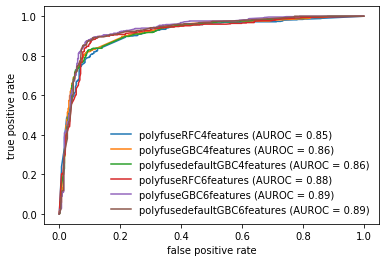

In [82]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)

In [83]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auprc = auc(recall, precision)
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

polyfuseRFC4features


NameError: name 'recall' is not defined

<Figure size 432x288 with 0 Axes>

In [20]:
arriba = pd.read_pickle('/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/LIB-04674wt/arriba/fusions.pkl')

In [21]:
arriba['confidence']

0      3
1      3
2      3
3      3
4      3
      ..
552    1
553    1
554    1
555    1
556    1
Name: confidence, Length: 557, dtype: int64

In [22]:
pizzly = pd.read_pickle('/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/LIB-04674wt/pizzly/fusions.pkl')

In [23]:
pizzly

,gene1,gene2,junction_reads,spanning_reads,caller,sample
0,KRT36,AC084121.11,8,0,pizzly,LIB-04674wt
1,KRT36,AC084121.6,7,0,pizzly,LIB-04674wt
2,KRT36,AC134684.11,4,0,pizzly,LIB-04674wt
3,KRT36,AC084121.7,8,0,pizzly,LIB-04674wt
4,KRT36,AC084121.5,8,0,pizzly,LIB-04674wt
...,...,...,...,...,...,...
737,DAZ4,TMEM217,5,0,pizzly,LIB-04674wt
738,DAZ1,TMEM217,5,0,pizzly,LIB-04674wt
739,HSH2D,TREH,27,5,pizzly,LIB-04674wt
740,MRPL51,REM2,37,6,pizzly,LIB-04674wt


In [24]:
x = pd.concat([pizzly, arriba], ignore_index=True, sort=False)

In [32]:
x.fusion

0       NaN             
1       NaN             
2       NaN             
3       NaN             
4       NaN             
       ...              
1294    RAB39B--RABGEF1 
1295    MUC16--UPK2     
1296    GAGE13--LRRC28  
1297    IL13RA1--TBC1D3G
1298    AP1S3--ARHGEF19 
Name: fusion, Length: 1299, dtype: object

In [40]:
x.loc[x.fusion_transcript.notna(), 'site1'].values[0]

'splice-site'